In [47]:

%%time

from datetime import datetime, timedelta, timezone
import json
import os
import re
import boto3
from time import sleep
from threading import Thread

import pandas as pd

from sagemaker import get_execution_role, session, Session, image_uris
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.processing import ProcessingJob
from sagemaker.serializers import CSVSerializer

from sagemaker.model import Model
from sagemaker.model_monitor import DataCaptureConfig

session = Session()

CPU times: user 65 ms, sys: 8.25 ms, total: 73.2 ms
Wall time: 87.9 ms


In [48]:
# Get Execution role
role = get_execution_role()
print("RoleArn:", role)

region = session.boto_region_name
print("Region:", region)

RoleArn: arn:aws:iam::133562267374:role/service-role/AmazonSageMaker-ExecutionRole-20210715T185402
Region: us-west-2


In [49]:

# Setup S3 bucket
# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the data is captured
bucket = session.default_bucket()
print("Demo Bucket:", bucket)
prefix = "sagemaker"

##S3 prefixes
data_capture_prefix = f"{prefix}/datacapture"
s3_capture_upload_path = f"s3://{bucket}/{data_capture_prefix}"

ground_truth_upload_path = (
    f"s3://{bucket}/{prefix}/ground_truth_data/{datetime.now():%Y-%m-%d-%H-%M-%S}"
)

reports_prefix = f"{prefix}/reports"
s3_report_path = f"s3://{bucket}/{reports_prefix}"

##Get the model monitor image
monitor_image_uri = image_uris.retrieve(framework="model-monitor", region=region)

print("Image URI:", monitor_image_uri)
print(f"Capture path: {s3_capture_upload_path}")
print(f"Ground truth path: {ground_truth_upload_path}")
print(f"Report path: {s3_report_path}")

Demo Bucket: sagemaker-us-west-2-133562267374
Image URI: 159807026194.dkr.ecr.us-west-2.amazonaws.com/sagemaker-model-monitor-analyzer
Capture path: s3://sagemaker-us-west-2-133562267374/sagemaker/datacapture
Ground truth path: s3://sagemaker-us-west-2-133562267374/sagemaker/ground_truth_data/2021-10-27-21-20-13
Report path: s3://sagemaker-us-west-2-133562267374/sagemaker/reports


In [50]:
##Upload the pretrained model to S3
s3_key = f"s3://{bucket}/{prefix}"
model_url = S3Uploader.upload("model/xgb-churn-prediction-model.tar.gz", s3_key)
model_url

's3://sagemaker-us-west-2-133562267374/sagemaker/xgb-churn-prediction-model.tar.gz'

In [51]:
model_name = f"DEMO-xgb-churn-pred-model-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"

image_uri = image_uris.retrieve(framework="xgboost", version="0.90-1", region=region)

model = Model(image_uri=image_uri, model_data=model_url, role=role, sagemaker_session=session)

In [52]:
endpoint_name = f"DEMO-xgb-churn-model-quality-monitor-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

data_capture_config = DataCaptureConfig(
    enable_capture=True, sampling_percentage=100, destination_s3_uri=s3_capture_upload_path
)

model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
)

EndpointName = DEMO-xgb-churn-model-quality-monitor-2021-10-27-2120
----------------!

In [53]:
from sagemaker.predictor import Predictor

predictor = Predictor(
    endpoint_name=endpoint_name, sagemaker_session=session, serializer=CSVSerializer()
)

In [54]:
churn_cutoff = 0.8
validate_dataset = "validation_with_predictions.csv"

In [ ]:

limit = 200  # Need at least 200 samples to compute standard deviations
i = 0
with open(f"test_data/{validate_dataset}", "w") as baseline_file:
    print("Escrevendo Header")
    baseline_file.write("probability,prediction,label\n") # our header
    print("abrindo csv de com dados de validacao")
    with open("test_data/validation.csv", "r") as f:
        for row in f:
            (label, input_cols) = row.split(",", 1)
            probability = float(predictor.predict(input_cols))            
            prediction = "1" if probability > churn_cutoff else "0"
            baseline_file.write(f"{probability},{prediction},{label}\n")
            print(f"{probability},{prediction},{label}\n")
            i += 1
            if i > limit:
                break
            print(".", end="", flush=True)
            sleep(0.5)
print()
print("Done!")

In [56]:
!head test_data/validation_with_predictions.csv

probability,prediction,label
0.01516005303710699,0,0
0.1684480607509613,0,0
0.21427156031131744,0,0
0.06330718100070953,0,0
0.02791607193648815,0,0
0.014169521629810333,0,0
0.00571369007229805,0,0
0.10534518957138062,0,0
0.025899196043610573,0,0


In [57]:

baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = f"s3://{bucket}/{baseline_data_prefix}"
baseline_results_uri = f"s3://{bucket}/{baseline_results_prefix}"
print(f"Baseline data uri: {baseline_data_uri}")
print(f"Baseline results uri: {baseline_results_uri}")

Baseline data uri: s3://sagemaker-us-west-2-133562267374/sagemaker/baselining/data
Baseline results uri: s3://sagemaker-us-west-2-133562267374/sagemaker/baselining/results


In [58]:
baseline_dataset_uri = S3Uploader.upload(f"test_data/{validate_dataset}", baseline_data_uri)
baseline_dataset_uri

's3://sagemaker-us-west-2-133562267374/sagemaker/baselining/data/validation_with_predictions.csv'

In [59]:
from sagemaker.model_monitor import ModelQualityMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat

In [60]:
# Create the model quality monitoring object
churn_model_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=session,
)

In [61]:
# Name of the model quality baseline job
baseline_job_name = f"DEMO-xgb-churn-model-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"

In [62]:
# Execute the baseline suggestion job.
# You will specify problem type, in this case Binary Classification, and provide other required attributes.
job = churn_model_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="prediction",
    probability_attribute="probability",
    ground_truth_attribute="label",
)
job.wait(logs=False)


Job Name:  DEMO-xgb-churn-model-baseline-job-2021-10-27-2139
Inputs:  [{'InputName': 'baseline_dataset_input', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-133562267374/sagemaker/baselining/data/validation_with_predictions.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-133562267374/sagemaker/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
........................................................................!

In [63]:

baseline_job = churn_model_quality_monitor.latest_baselining_job

In [64]:
binary_metrics = baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]
pd.json_normalize(binary_metrics).T

,0
confusion_matrix.0.0,173
confusion_matrix.0.1,0
confusion_matrix.1.0,12
confusion_matrix.1.1,16
recall.value,0.571429
recall.standard_deviation,0.0299822
precision.value,1
precision.standard_deviation,0
accuracy.value,0.940299
accuracy.standard_deviation,0.00589373


In [65]:
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,0.571429,LessThanThreshold
precision,1,LessThanThreshold
accuracy,0.940299,LessThanThreshold
true_positive_rate,0.571429,LessThanThreshold
true_negative_rate,1,LessThanThreshold
false_positive_rate,0,GreaterThanThreshold
false_negative_rate,0.428571,GreaterThanThreshold
auc,0.939513,LessThanThreshold
f0_5,0.869565,LessThanThreshold
f1,0.727273,LessThanThreshold


In [66]:

def invoke_endpoint(ep_name, file_name):
    with open(file_name, "r") as f:
        i = 0
        for row in f:
            payload = row.rstrip("\n")
            response = session.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)


def invoke_endpoint_forever():
    while True:
        invoke_endpoint(endpoint_name, "test_data/test-dataset-input-cols.csv")


thread = Thread(target=invoke_endpoint_forever)
thread.start()

In [67]:
print("Waiting for captures to show up", end="")
for _ in range(120):
    capture_files = sorted(S3Downloader.list(f"{s3_capture_upload_path}/{endpoint_name}"))
    if capture_files:
        capture_file = S3Downloader.read_file(capture_files[-1]).split("\n")
        capture_record = json.loads(capture_file[0])
        if "inferenceId" in capture_record["eventMetadata"]:
            break
    print(".", end="", flush=True)
    sleep(1)
print()
print("Found Capture Files:")
print("\n ".join(capture_files[-3:]))

Waiting for captures to show up...................................
Found Capture Files:
s3://sagemaker-us-west-2-133562267374/sagemaker/datacapture/DEMO-xgb-churn-model-quality-monitor-2021-10-27-2120/AllTraffic/2021/10/27/21/37-26-684-70e04e64-8268-40aa-aa32-6f926e9674fb.jsonl
 s3://sagemaker-us-west-2-133562267374/sagemaker/datacapture/DEMO-xgb-churn-model-quality-monitor-2021-10-27-2120/AllTraffic/2021/10/27/21/38-26-755-72873503-80be-407b-802a-56a34a99c23c.jsonl
 s3://sagemaker-us-west-2-133562267374/sagemaker/datacapture/DEMO-xgb-churn-model-quality-monitor-2021-10-27-2120/AllTraffic/2021/10/27/21/46-18-664-385c8cd4-406b-4a3c-8a04-7fc86da9941a.jsonl


In [68]:
print("\n".join(capture_file[-3:-1]))

{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"61,0,260.0,123,210.5,127,234.7,70,9.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"0.5217539072036743","encoding":"CSV"}},"eventMetadata":{"eventId":"20d3a7ca-1641-4180-a225-0af7a5caf199","inferenceId":"57","inferenceTime":"2021-10-27T21:47:16Z"},"eventVersion":"0"}
{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"41,0,159.3,66,125.9,75,261.9,76,11.1,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"0.01216088142246008","encoding":"CSV"}},"eventMetadata":{"eventId":"aba5a425-1f87-4da1-bcda-521e759dbdf1"

In [69]:
print(json.dumps(capture_record, indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "186,0.1,137.8,97,187.7,118,146.4,85,8.7,6,1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,1.1,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,1.2,1.3,0.54,1.4,0.55",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.01584203727543354",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "12e96da5-6ca0-442c-9edf-dd73b92bdec2",
    "inferenceId": "0",
    "inferenceTime": "2021-10-27T21:46:18Z"
  },
  "eventVersion": "0"
}


In [70]:
import random


def ground_truth_with_id(inference_id):
    random.seed(inference_id)  # to get consistent results
    rand = random.random()
    return {
        "groundTruthData": {
            "data": "1" if rand < 0.7 else "0",  # randomly generate positive labels 70% of the time
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }


def upload_ground_truth(records, upload_time):
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)

In [71]:
NUM_GROUND_TRUTH_RECORDS = 334  # 334 are the number of rows in data we're sending for inference


def generate_fake_ground_truth_forever():
    j = 0
    while True:
        fake_records = [ground_truth_with_id(i) for i in range(NUM_GROUND_TRUTH_RECORDS)]
        upload_ground_truth(fake_records, datetime.utcnow())
        j = (j + 1) % 5
        sleep(60 * 60)  # do this once an hour


gt_thread = Thread(target=generate_fake_ground_truth_forever)
gt_thread.start()

Uploading 334 records to s3://sagemaker-us-west-2-133562267374/sagemaker/ground_truth_data/2021-10-27-21-20-13/2021/10/27/21/4737.jsonl


In [72]:

##Monitoring schedule name
churn_monitor_schedule_name = (
    f"DEMO-xgb-churn-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}"
)

In [73]:
# Create an enpointInput
endpointInput = EndpointInput(
    endpoint_name=predictor.endpoint_name,
    probability_attribute="0",
    probability_threshold_attribute=0.5,
    destination="/opt/ml/processing/input_data",
)

In [74]:
# Create the monitoring schedule to execute every hour.
from sagemaker.model_monitor import CronExpressionGenerator

response = churn_model_quality_monitor.create_monitoring_schedule(
    monitor_schedule_name=churn_monitor_schedule_name,
    endpoint_input=endpointInput,
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    ground_truth_input=ground_truth_upload_path,
    constraints=baseline_job.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

In [76]:
churn_model_quality_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-west-2:133562267374:monitoring-schedule/demo-xgb-churn-monitoring-schedule-2021-10-27-2148',
 'MonitoringScheduleName': 'DEMO-xgb-churn-monitoring-schedule-2021-10-27-2148',
 'MonitoringScheduleStatus': 'Pending',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2021, 10, 27, 21, 49, 6, 147000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2021, 10, 27, 21, 49, 11, 582000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinitionName': 'model-quality-job-definition-2021-10-27-21-49-05-864',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'DEMO-xgb-churn-model-quality-monitor-2021-10-27-2120',
 'ResponseMetadata': {'RequestId': '06d9e206-8d7b-4df8-bfad-4d6f30e9c50a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '06d9e206-8d7b-4df8-bfad-4d6f30e9c50a',
   'content-type': 'application/x-amz-json-1.1',
   'c

In [79]:
executions = churn_model_quality_monitor.list_executions()
executions

In [ ]:
# Wait for the first execution of the monitoring_schedule
print("Waiting for first execution", end="")
while True:
    execution = churn_model_quality_monitor.describe_schedule().get(
        "LastMonitoringExecutionSummary"
    )
    if execution:
        break
    print(".", end="", flush=True)
    sleep(10)
print()
print("Execution found!")

Waiting for first execution..............................................................................

In [80]:
while not executions:
    executions = churn_model_quality_monitor.list_executions()
    sleep(10)
latest_execution = executions[-1]
latest_execution.describe()

{'ProcessingInputs': [{'InputName': 'constraints',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-133562267374/sagemaker/baselining/results/constraints.json',
    'LocalPath': '/opt/ml/processing/baseline/constraints',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated'}},
  {'InputName': 'endpoint_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-133562267374/sagemaker/baselining/results/merge/DEMO-xgb-churn-model-quality-monitor-2021-10-27-2120/AllTraffic/2021/10/27/21',
    'LocalPath': '/opt/ml/processing/input_data/DEMO-xgb-churn-model-quality-monitor-2021-10-27-2120/AllTraffic/2021/10/27/21',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'result',
    'S3Output': {'S3Uri': 's3://sagemaker-us-west-2-133562267374/sagemake

In [85]:
status = execution["MonitoringExecutionStatus"]

while status in ["Pending", "InProgress"]:
    print("Waiting for execution to finish", end="")
    latest_execution.wait(logs=False)
    latest_job = latest_execution.describe()
    print()
    print(f"{latest_job['ProcessingJobName']} job status:", latest_job["ProcessingJobStatus"])
    print(
        f"{latest_job['ProcessingJobName']} job exit message, if any:",
        latest_job.get("ExitMessage"),
    )
    print(
        f"{latest_job['ProcessingJobName']} job failure reason, if any:",
        latest_job.get("FailureReason"),
    )
    sleep(
        30
    )  # model quality executions consist of two Processing jobs, wait for second job to start
    latest_execution = churn_model_quality_monitor.list_executions()[-1]
    execution = churn_model_quality_monitor.describe_schedule()["LastMonitoringExecutionSummary"]
    status = execution["MonitoringExecutionStatus"]

print("Execution status is:", status)

if status != "Completed":
    print(execution)
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

Execution status is: CompletedWithViolations
{'MonitoringScheduleName': 'DEMO-xgb-churn-monitoring-schedule-2021-10-27-2148', 'ScheduledTime': datetime.datetime(2021, 10, 27, 22, 0, tzinfo=tzlocal()), 'CreationTime': datetime.datetime(2021, 10, 27, 22, 5, 8, 660000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2021, 10, 27, 22, 17, 24, 516000, tzinfo=tzlocal()), 'MonitoringExecutionStatus': 'CompletedWithViolations', 'ProcessingJobArn': 'arn:aws:sagemaker:us-west-2:133562267374:processing-job/model-quality-monitoring-202110272200-ce483132c2f520355cc086d7', 'EndpointName': 'DEMO-xgb-churn-model-quality-monitor-2021-10-27-2120'}
====STOP==== 
 No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures.


In [86]:


latest_execution = churn_model_quality_monitor.list_executions()[-1]
report_uri = latest_execution.describe()["ProcessingOutputConfig"]["Outputs"][0]["S3Output"][
    "S3Uri"
]
print("Report Uri:", report_uri)



Report Uri: s3://sagemaker-us-west-2-133562267374/sagemaker/baselining/results/DEMO-xgb-churn-model-quality-monitor-2021-10-27-2120/DEMO-xgb-churn-monitoring-schedule-2021-10-27-2148/2021/10/27/23


In [92]:

pd.options.display.max_colwidth = None
violations = latest_execution.constraint_violations().body_dict["violations"]
violations_df = pd.json_normalize(violations)
violations_df.head(10)

,constraint_check_type,description,metric_name
0,LessThanThreshold,Metric auc with 0.515453080147537 +/- 8.080858763541535E-4 was LessThanThreshold '0.9395127993393898',auc
1,LessThanThreshold,Metric precision with 0.6980576809888169 +/- 0.0019203274194891395 was LessThanThreshold '1.0',precision
2,LessThanThreshold,Metric truePositiveRate with 0.11591086786551993 +/- 0.0014500957184854933 was LessThanThreshold '0.5714285714285714',truePositiveRate
3,LessThanThreshold,Metric f1 with 0.19880982314977788 +/- 0.002169255376176902 was LessThanThreshold '0.7272727272727273',f1
4,LessThanThreshold,Metric accuracy with 0.32397454031117395 +/- 6.096306931571001E-4 was LessThanThreshold '0.9402985074626866',accuracy
5,GreaterThanThreshold,Metric falsePositiveRate with 0.1312691914022518 +/- 0.0018092804739749451 was GreaterThanThreshold '0.0',falsePositiveRate
6,LessThanThreshold,Metric trueNegativeRate with 0.8687308085977482 +/- 0.0018092804739749599 was LessThanThreshold '1.0',trueNegativeRate
7,GreaterThanThreshold,Metric falseNegativeRate with 0.88408913213448 +/- 0.0014500957184855029 was GreaterThanThreshold '0.4285714285714286',falseNegativeRate
8,LessThanThreshold,Metric recall with 0.11591086786551993 +/- 0.0014500957184854933 was LessThanThreshold '0.5714285714285714',recall
9,LessThanThreshold,Metric f2 with 0.13911370727473196 +/- 0.0016779544709614818 was LessThanThreshold '0.625',f2


In [89]:

# Create CloudWatch client
cw_client = boto3.Session().client("cloudwatch")

namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_dimensions = [
    {"Name": "Endpoint", "Value": endpoint_name},
    {"Name": "MonitoringSchedule", "Value": churn_monitor_schedule_name},
]

In [90]:

# List metrics through the pagination interface
paginator = cw_client.get_paginator("list_metrics")

for response in paginator.paginate(Dimensions=cw_dimensions, Namespace=namespace):
    model_quality_metrics = response["Metrics"]
    for metric in model_quality_metrics:
        print(metric["MetricName"])

f0_5_best_constant_classifier
f2_best_constant_classifier
f1_best_constant_classifier
auc
precision
accuracy_best_constant_classifier
true_positive_rate
f1
accuracy
false_positive_rate
f0_5
true_negative_rate
false_negative_rate
recall_best_constant_classifier
precision_best_constant_classifier
recall
f2


In [91]:
alarm_name = "MODEL_QUALITY_F2_SCORE"
alarm_desc = (
    "Trigger an CloudWatch alarm when the f2 score drifts away from the baseline constraints"
)
mdoel_quality_f2_drift_threshold = (
    0.625  ##Setting this threshold purposefully low to see the alarm quickly.
)
metric_name = "f2"
namespace = "aws/sagemaker/Endpoints/model-metrics"

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    MetricName=metric_name,
    Namespace=namespace,
    Statistic="Average",
    Dimensions=[
        {"Name": "Endpoint", "Value": endpoint_name},
        {"Name": "MonitoringSchedule", "Value": churn_monitor_schedule_name},
    ],
    Period=600,
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Threshold=mdoel_quality_f2_drift_threshold,
    ComparisonOperator="LessThanOrEqualToThreshold",
    TreatMissingData="breaching",
)

{'ResponseMetadata': {'RequestId': 'bbe08387-698c-4a49-a661-6dcce56fa254',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bbe08387-698c-4a49-a661-6dcce56fa254',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Wed, 27 Oct 2021 23:16:55 GMT'},
  'RetryAttempts': 0}}

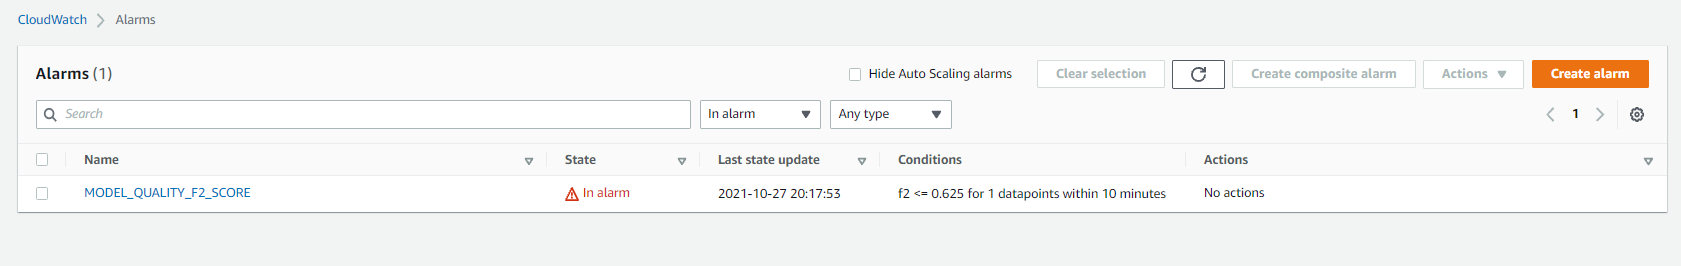


In [93]:
churn_model_quality_monitor.delete_monitoring_schedule()


Deleting Monitoring Schedule with name: DEMO-xgb-churn-monitoring-schedule-2021-10-27-2148


In [94]:
predictor.delete_endpoint()
predictor.delete_model()

ClientError: An error occurred (ValidationException) when calling the DescribeEndpointConfig operation: Could not find endpoint configuration "arn:aws:sagemaker:us-west-2:133562267374:endpoint-config/demo-xgb-churn-model-quality-monitor-2021-10-27-2120".

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-66-66f5d32c9212>", line 18, in invoke_endpoint_forever
    invoke_endpoint(endpoint_name, "test_data/test-dataset-input-cols.csv")
  File "<ipython-input-66-66f5d32c9212>", line 10, in invoke_endpoint
    InferenceId=str(i),  # unique ID per row
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/botocore/client.py", line 386, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/botocore/client.py", line 705, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.ValidationError: An error occurred 

Uploading 334 records to s3://sagemaker-us-west-2-133562267374/sagemaker/ground_truth_data/2021-10-27-21-20-13/2021/10/27/23/4738.jsonl
Uploading 334 records to s3://sagemaker-us-west-2-133562267374/sagemaker/ground_truth_data/2021-10-27-21-20-13/2021/10/28/00/0755.jsonl
Uploading 334 records to s3://sagemaker-us-west-2-133562267374/sagemaker/ground_truth_data/2021-10-27-21-20-13/2021/10/28/00/4738.jsonl
Uploading 334 records to s3://sagemaker-us-west-2-133562267374/sagemaker/ground_truth_data/2021-10-27-21-20-13/2021/10/28/01/0756.jsonl
Uploading 334 records to s3://sagemaker-us-west-2-133562267374/sagemaker/ground_truth_data/2021-10-27-21-20-13/2021/10/28/01/4739.jsonl
Uploading 334 records to s3://sagemaker-us-west-2-133562267374/sagemaker/ground_truth_data/2021-10-27-21-20-13/2021/10/28/02/0756.jsonl
Uploading 334 records to s3://sagemaker-us-west-2-133562267374/sagemaker/ground_truth_data/2021-10-27-21-20-13/2021/10/28/02/4739.jsonl
